# Bayesian NN Demo Using VIX

Ideas:
* Compare a simple time series forecast using both regular NN and Bayesian
    * E.g.: asset return, randomly generated time series etc.
* Test a simple VIX forecasting exercise using different variants

### VIX demonstration

#### VIX

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Import VIX daily closing values from FRED dataset

In [43]:
vix = pd.read_csv("data/VIXCLS.csv", parse_dates=["DATE"], decimal=".")
vix["VIXCLS"] = pd.to_numeric(vix.VIXCLS, errors="coerce")

Plot monthly average value

<AxesSubplot: xlabel='DATE', ylabel='VIXCLS'>

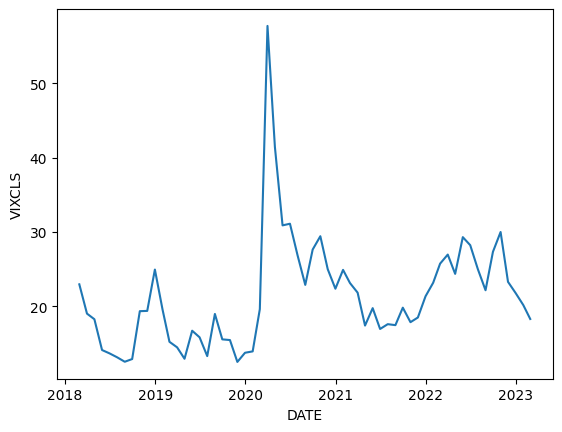

In [51]:
sns.lineplot(vix.groupby(pd.Grouper(key="DATE", freq="M")).mean(), x="DATE", y="VIXCLS")

<AxesSubplot: xlabel='DATE', ylabel='VIXCLS'>

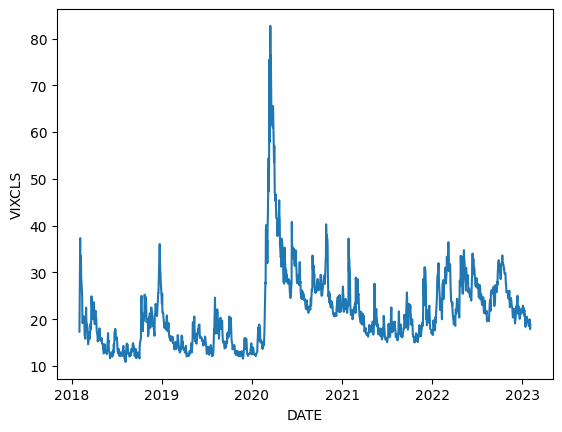

In [ ]:
# Plot overall
sns.lineplot(vix, x="DATE", y="VIXCLS")

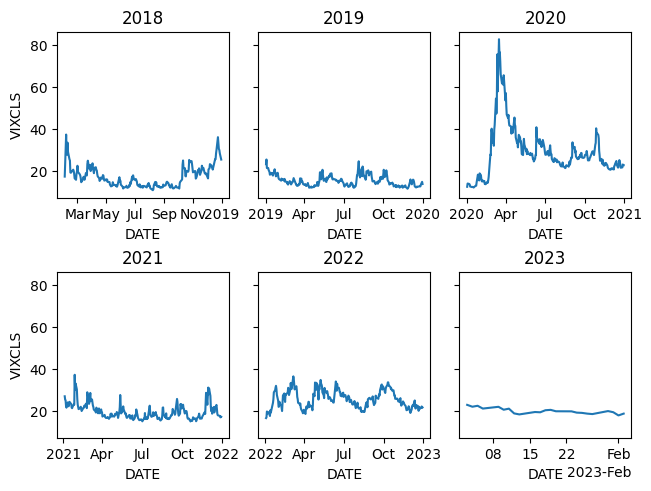

In [94]:
import matplotlib.dates as mdates
fig, axs = plt.subplots(2, 3, constrained_layout=True, sharey=True)
for ax, year in zip(axs.ravel(), vix.DATE.dt.year.unique()):
    sns.lineplot(vix.loc[vix.DATE.dt.year == year], x="DATE", y="VIXCLS", ax=ax)
    ax.set_title(year)
    #locator = mdates.MonthLocator(interval=3)
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    #ax.tick_params(axis="x", labelrotation=30, labelright=True)

In [96]:
np.log(vix.VIXCLS)

0       2.851284
1       3.619529
2       3.400530
3       3.322515
4       3.510351
          ...   
1300    2.918311
1301    2.992728
1302    2.965273
1303    2.883123
1304    2.930127
Name: VIXCLS, Length: 1305, dtype: float64

#### Forecasting using regular LSTM

Split data into 70/20/10 for training/validation/test

In [108]:
import tensorflow_probability as tfp
import tensorflow as tf

In [126]:
df = vix.dropna()
n = len(df)
train_df = df.iloc[0:int(n*0.7)]
val_df = df.iloc[int(n*0.7):int(n*0.9)]
test_df = df.iloc[int(n*0.9):]

Create rolling window

In [606]:
dataset = tf.data.Dataset.from_tensor_slices(train_df.VIXCLS)
window_size = 30
shuffle_buffer = 1000
batch_size = 32
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
dataset = dataset.shuffle(shuffle_buffer)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
dataset = dataset.batch(batch_size).prefetch(1)

Create model

In [733]:
def create_uncompiled_model():
  # define a sequential model
    model = tf.keras.models.Sequential([ 
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                    input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),# return_sequences=True)),
      #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1),
    ]) 

    return model

class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):

        if(logs.get('mae') < 0.03):
            print("\nMAEthreshold reached. Training stopped.")
            self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()


def create_model():
    tf.random.set_seed(51)
  
    model = create_uncompiled_model()
  
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mae"])  
    return model
  
lstm_model = create_model()

In [734]:
history = lstm_model.fit(dataset, epochs=20, callbacks=[early_stopping])

Epoch 1/20
27/27 [==============================] - 7s 23ms/step - loss: 17.7998 - mae: 18.2998
Epoch 2/20
27/27 [==============================] - 1s 19ms/step - loss: 11.6645 - mae: 12.1635
Epoch 3/20
27/27 [==============================] - 1s 18ms/step - loss: 6.6850 - mae: 7.1546
Epoch 4/20
27/27 [==============================] - 1s 20ms/step - loss: 5.5271 - mae: 6.0036
Epoch 5/20
27/27 [==============================] - 1s 19ms/step - loss: 5.1788 - mae: 5.6572
Epoch 6/20
27/27 [==============================] - 1s 19ms/step - loss: 4.5871 - mae: 5.0561
Epoch 7/20
27/27 [==============================] - 1s 19ms/step - loss: 3.8486 - mae: 4.3056
Epoch 8/20
27/27 [==============================] - 1s 19ms/step - loss: 3.1884 - mae: 3.6262
Epoch 9/20
27/27 [==============================] - 1s 18ms/step - loss: 2.8392 - mae: 3.2712
Epoch 10/20
27/27 [==============================] - 1s 18ms/step - loss: 2.5164 - mae: 2.9328
Epoch 11/20
27/27 [==============================] - 1s

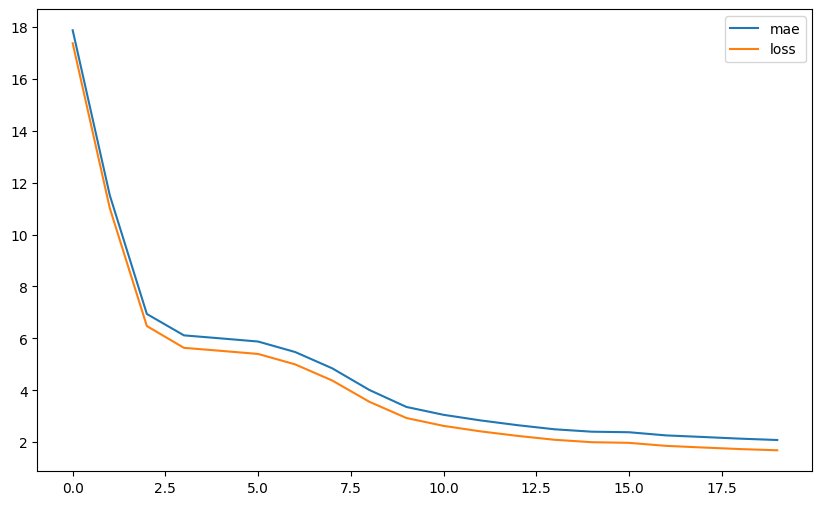

In [209]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [372]:
def model_forecast(model, series, window_size):
#"This function converts the input series into a dataset with time windows for forecasting"
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [735]:
lstm_forecast = model_forecast(lstm_model, val_df.VIXCLS, window_size)

7/7 [==============================] - 1s 13ms/step


In [379]:
temp = val_df.iloc[29:].copy()
temp["predictions"] = val_forecast.squeeze()

#### Regular NN plot

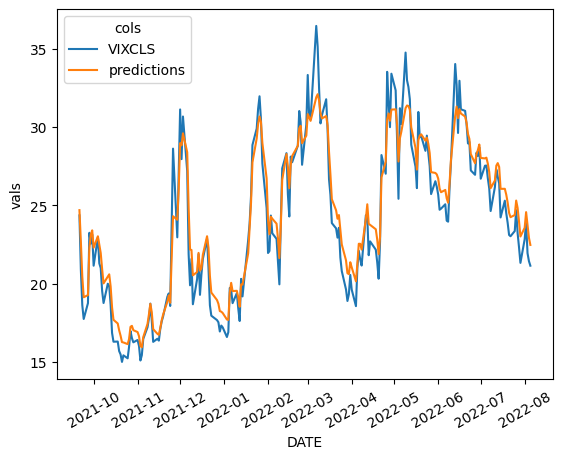

In [380]:
ax = sns.lineplot(temp.melt('DATE', var_name='cols', value_name='vals'), x="DATE", y="vals", hue="cols")
ax.tick_params(axis="x", labelrotation=30, labelright=True)

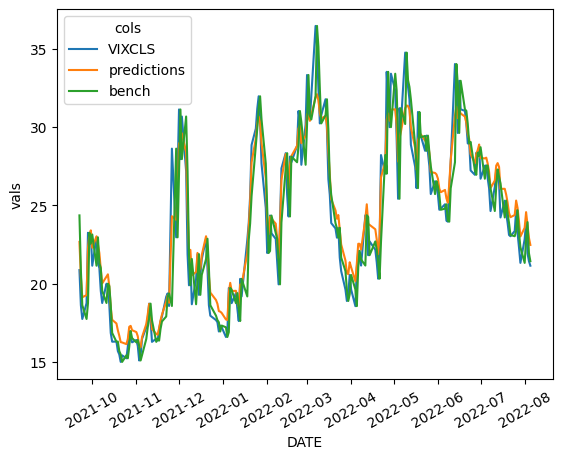

In [381]:
temp["bench"] = 0
temp.iloc[1:, -1] = temp.iloc[:-1, 1]
ax = sns.lineplot(temp.iloc[1:].melt('DATE', var_name='cols', value_name='vals'), x="DATE", y="vals", hue="cols")
ax.tick_params(axis="x", labelrotation=30, labelright=True)

#### Bayesian 

Create function for maximizing the log likelihood

In [602]:
# Minimize negative loglikelihood
negloglik = lambda y, p_y: -p_y.log_prob(y)

For demonstrative purposes, the next few cells will demonstrate aleatoric and epistemic uncertainty by forecasting the validation period.

##### Aleatoric uncertainty demonstration

##### Epistemic uncertainty demonstration

##### Demo

In [177]:
tfd = tfp.distributions

In [603]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

In [604]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

In [688]:
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
            input_shape=[None]),
    tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])
                            )
    )
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik)
model.fit(dataset, epochs=1000, verbose=False)

In [695]:
yhats[0].shape

(224, 30, 1)

In [652]:
# Create validation dataset
ds = tf.data.Dataset.from_tensor_slices(val_df.VIXCLS)
ds = ds.window(window_size, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda w: w.batch(window_size))
ds = ds.batch(32).prefetch(1)

In [689]:
yhats = [model.predict(ds, verbose=False) for _ in range(100)]

In [690]:
avgm = np.zeros(shape=(yhats[0].shape[0]))
std = np.zeros(shape=(yhats[0].shape[0]))
for i, yhat in enumerate(yhats):
    # Get mean and stddev for each day
    means = yhat.mean(axis=1).squeeze()
    stds = yhat.std(axis=1).squeeze()
    avgm += means
    std += stds

tot_avg = avgm / len(yhats)
tot_std = std/ len(yhats) 

In [660]:
# Try plotting one model run: aleatoric uncertainty
fc = model.predict(ds, verbose=False)
avg_val = fc.mean(axis=1).squeeze()
std_val = fc.std(axis=1).squeeze()

In [691]:
temp = val_df.copy()
temp[["mean_pred", "std_pred"]] = 0
temp.iloc[29:, -2] = tot_avg
temp.iloc[29:, -1] = tot_std

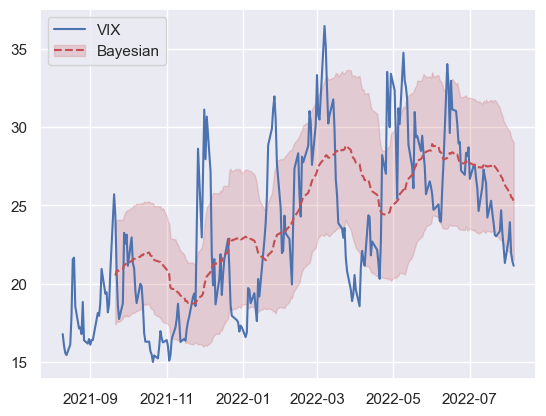

In [692]:
#dd = temp.melt('DATE', var_name='cols', value_name='vals')
sns.set()
temp_for = temp.iloc[29:]
actual, = plt.plot(temp.DATE, temp.VIXCLS, 'b-')
pred, = plt.plot(temp_for.DATE, temp_for.mean_pred, 'r--')
fill_pred = plt.fill_between(
    temp_for.DATE, 
    temp_for.mean_pred - temp_for.std_pred, temp_for.mean_pred + temp_for.std_pred, 
    color='r', alpha=0.2
)

plt.legend([actual, (pred, fill_pred)], ["VIX","Bayesian"])

In [696]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
            input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])
                            )
    )
])

new_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik)
new_model.fit(dataset, epochs=1000, verbose=False)

In [704]:
f3 = [new_model.predict(ds, verbose=False) for _ in range(100)]

In [ ]:
avgm = np.zeros(shape=(f3[0].shape[0]))
std = np.zeros(shape=(f3[0].shape[0]))
for i, y in enumerate(f3):
    

In [719]:
avgm = np.zeros(shape=(len(f3), f3[0].shape[0]))
for i, yhat in enumerate(f3):
    # Get mean and stddev for each day
    avgm[i] = yhat.squeeze()

In [728]:
tot_avg = avgm.mean(axis=0)
tot_std = avgm.std(axis=0)

In [ ]:
temp = val_df.copy()
temp[["mean_pred", "std_pred"]] = 0
temp.iloc[29:, -2] = tot_avg
temp.iloc[29:, -1] = tot_std
temp_for = temp.iloc[29:]

#### Bayesian plot

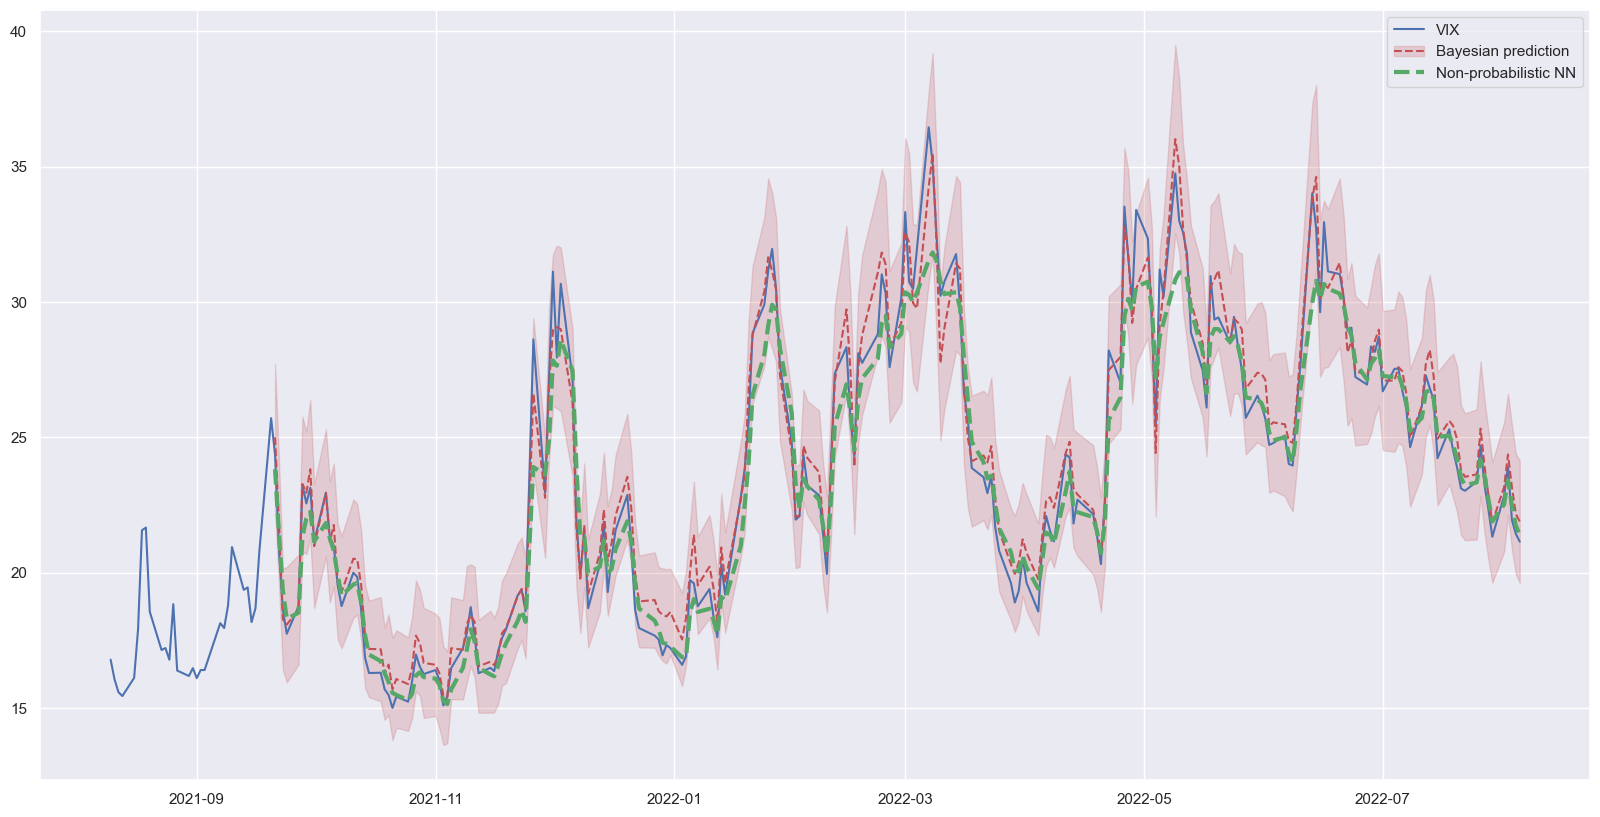

In [741]:
sns.set()
fig, axs = plt.subplots(figsize=(20, 10))
actual, = plt.plot(temp.DATE, temp.VIXCLS, 'b-')
pred, = plt.plot(temp_for.DATE, temp_for.mean_pred, 'r--')
lstm_pred, = plt.plot(temp_for.DATE, lstm_forecast, 'g--', linewidth=3)
fill_pred = plt.fill_between(
    temp_for.DATE, 
    temp_for.mean_pred - temp_for.std_pred, temp_for.mean_pred + temp_for.std_pred, 
    color='r', alpha=0.2
)

plt.legend([actual,(pred, fill_pred), lstm_pred], ["VIX","Bayesian prediction", "Non-probabilistic NN"]);

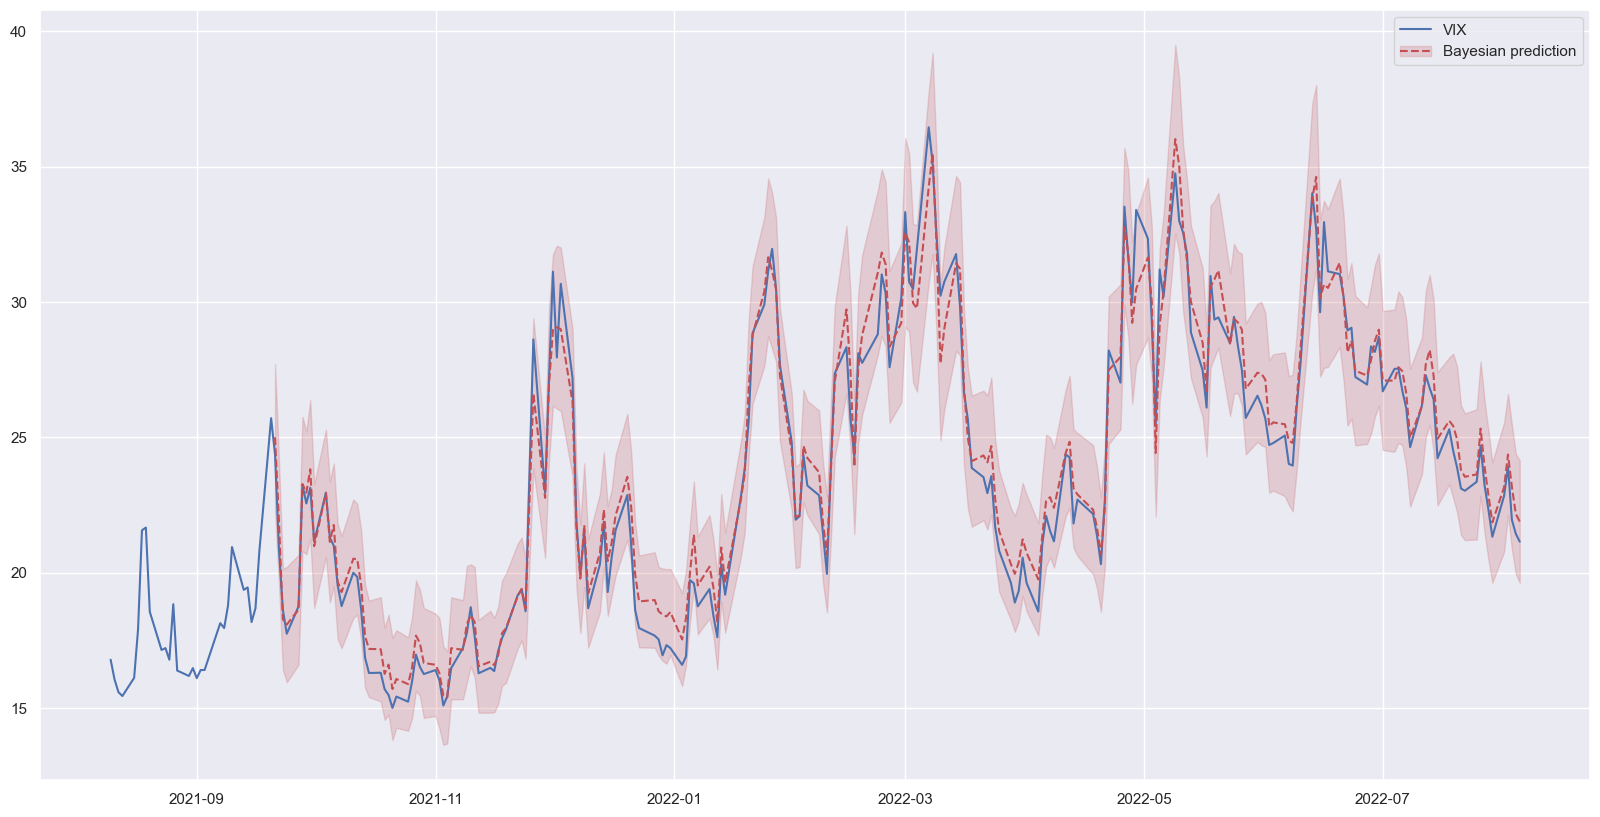

In [742]:
sns.set()
fig, axs = plt.subplots(figsize=(20, 10))
actual, = plt.plot(temp.DATE, temp.VIXCLS, 'b-')
pred, = plt.plot(temp_for.DATE, temp_for.mean_pred, 'r--')
fill_pred = plt.fill_between(
    temp_for.DATE, 
    temp_for.mean_pred - temp_for.std_pred, temp_for.mean_pred + temp_for.std_pred, 
    color='r', alpha=0.2
)

plt.legend([actual,(pred, fill_pred)], ["VIX","Bayesian prediction"]);

#### Predicting 30 days into the future

In [779]:
# Autoregressive: use mean predictions as data

# Initialize last 29 days plus final prediction as input
last_pred = tot_avg[-1]
last_vix = val_df.VIXCLS.iloc[-29:].to_numpy()
inputs = np.zeros(shape=(1, 30))
inputs[..., :-1] = last_vix
inputs[..., 29] = last_pred

samples = np.zeros((100, 30))
# Repeat for 30 days
for i in range(100):
    new_inputs = inputs.copy()
    for j in range(30):
        new_pred = new_model.predict(new_inputs, verbose=False)
        new_inputs[..., 29] = new_pred
        samples[i, j] = new_pred
    print(i, end=" ")
#all_preds = np.asarray([new_model.predict(inputs, verbose=False) for _ in range(100)])
#new_pred = all_preds.mean()
    

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [830]:
samples_mean = samples.mean(axis=0)
samples_std = samples.std(axis=0)

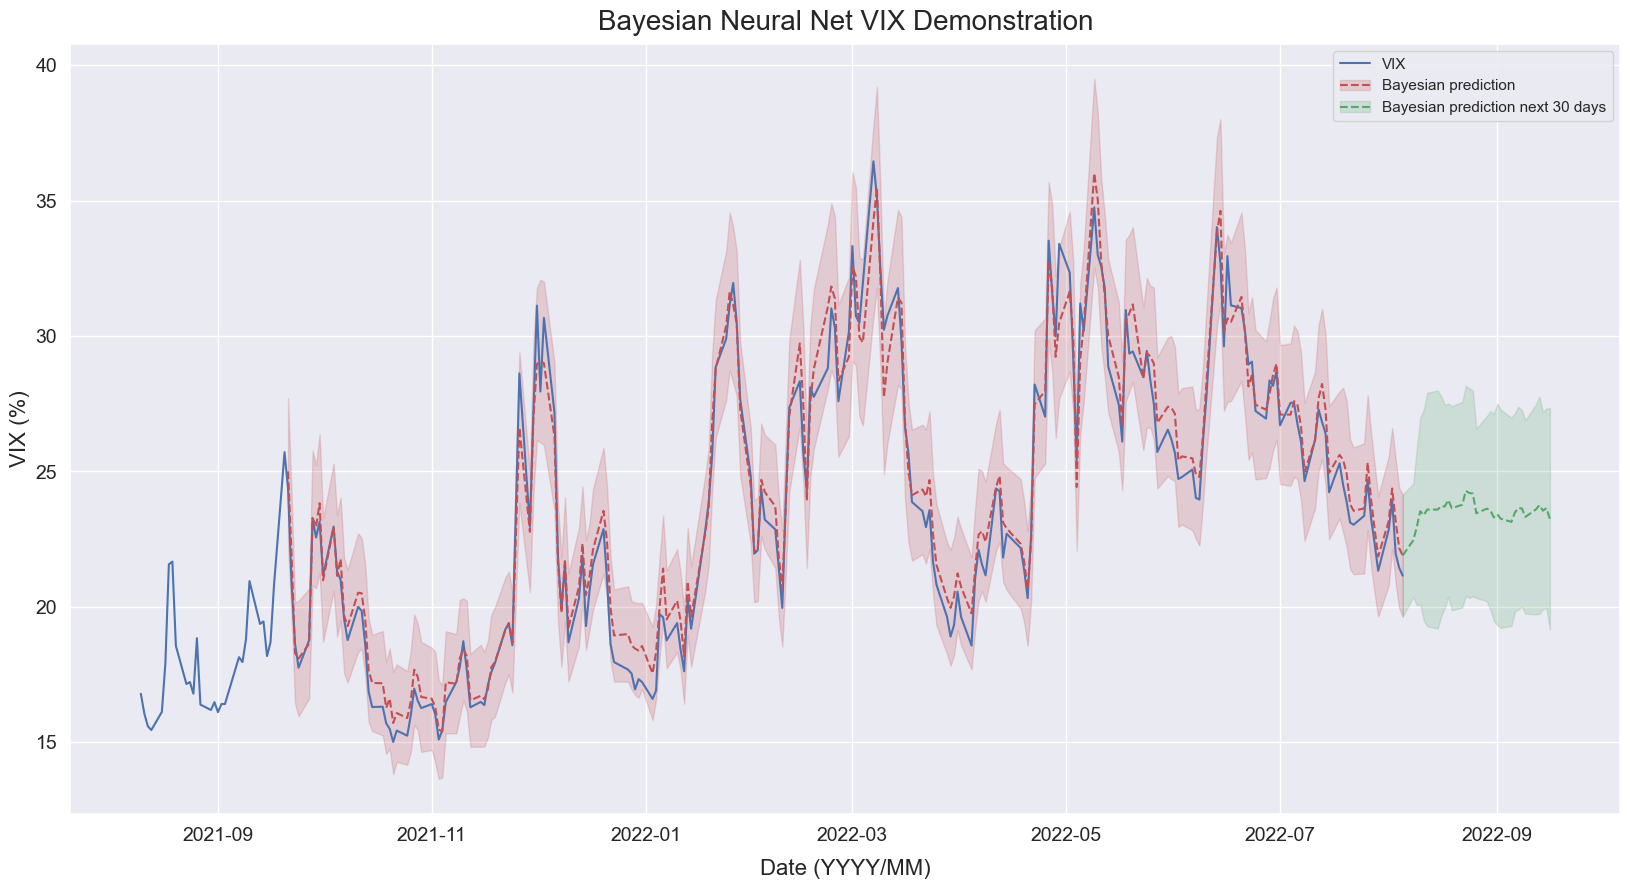

In [882]:
sns.set()
all_dates = pd.merge(temp, temp.DATE.iloc[-30:] + pd.offsets.BDay(30), how="outer")
all_dates.iloc[-30:, 2] = samples_mean
all_dates.iloc[-30:, 3] = samples_std
fig, axs = plt.subplots(figsize=(20, 10))
actual, = plt.plot(all_dates.DATE, all_dates.VIXCLS, 'b-')
pred, = plt.plot(all_dates.DATE.iloc[29:-30], all_dates.mean_pred.iloc[29:-30], 'r--')
fill_pred = plt.fill_between(
    all_dates.DATE.iloc[29:-30], 
    all_dates.mean_pred.iloc[29:-30] - all_dates.std_pred.iloc[29:-30], 
    all_dates.mean_pred.iloc[29:-30] + all_dates.std_pred.iloc[29:-30], 
    color='r', alpha=0.2
)
samples_pred, = plt.plot(all_dates.DATE.iloc[-31:], all_dates.mean_pred.iloc[-31:], 'g--')
fill_sample = plt.fill_between(
    all_dates.DATE.iloc[-31:],
    all_dates.mean_pred.iloc[-31:] - all_dates.std_pred.iloc[-31:], 
    all_dates.mean_pred.iloc[-31:] + all_dates.std_pred.iloc[-31:],
    color="g", alpha=0.2
)
plt.title("Bayesian Neural Net VIX Demonstration", fontsize=20, pad=10)
plt.xlabel("Date (YYYY/MM)", fontsize=16, labelpad=10)
plt.ylabel("VIX (%)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([actual,(pred, fill_pred), (samples_pred, fill_sample)], ["VIX","Bayesian prediction", "Bayesian prediction next 30 days"])
plt.savefig("bayesian");

#### Bayesian attempt 2

Create Gaussian priors with mean = 0 and stddev = 1

In [267]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

Define posterior as multivariate Gaussian

In [268]:
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n),
                dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n)
        ]
    )
    return posterior_model

In [389]:
# Create model
def create_prob_bnn(train_size):
    inputs = create_model_inputs()
    
    model = tf.keras.Sequential([
        tfk.keras.layers.DenseVariational(
            units=units, make_posterior_fn=posterior, make_prior_fn=prior,
            kl_weight=1/train_size
        ),
        tfp.layers.IndependentNormal(1)
    ])
    return model
    
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
            input_shape=[None]),
    tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])
                            )
    )
])




### New test

In [410]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(30,), name="input"),
    tfp.layers.DenseVariational(units=2, make_posterior_fn=posterior, make_prior_fn=prior, kl_weight=1/len(train_df)),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., 1],
                             scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])
                            )
    )
])

In [394]:
model.compile(optimizer="adam", loss=negloglik)

In [397]:
dataset = tf.data.Dataset.from_tensor_slices(train_df.VIXCLS)
window_size = 30
shuffle_buffer = 1000
batch_size = 32
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
dataset = dataset.shuffle(shuffle_buffer)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
dataset = dataset.batch(batch_size).prefetch(1)

In [398]:
val_data = tf.data.Dataset.from_tensor_slices(val_df.VIXCLS)
window_size = 30
shuffle_buffer = 1000
batch_size = 32
val_data = val_data.window(window_size + 1, shift=1, drop_remainder=True)
val_data = val_data.flat_map(lambda window: window.batch(window_size + 1))
val_data = val_data.shuffle(shuffle_buffer)
val_data = val_data.map(lambda window: (window[:-1], window[-1]))
val_data = val_data.batch(batch_size).prefetch(1)

In [401]:
test_data = tf.data.Dataset.from_tensor_slices(test_df.VIXCLS)
window_size = 30
shuffle_buffer = 1000
batch_size = 32
test_data = test_data.window(window_size + 1, shift=1, drop_remainder=True)
test_data = test_data.flat_map(lambda window: window.batch(window_size + 1))
test_data = test_data.shuffle(shuffle_buffer)
test_data = test_data.map(lambda window: (window[:-1], window[-1]))
test_data = test_data.batch(batch_size).prefetch(1)

In [399]:
model.fit(dataset, epochs=20, validation_data=val_data, verbose=False)

In [418]:
f = model.predict(test_data, verbose=False)
f.values

<tf.Tensor: shape=(3073,), dtype=float32, numpy=
array([38.726273, 27.076296, 31.124712, ..., 87.41653 , 88.86631 ,
        9.988587], dtype=float32)>

In [408]:
samples = 500
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(test_data)
X_true, Y_true, Y_pred = np.empty(shape=(samples, 30)), np.empty(shape=(samples, 2)), np.empty(shape=(samples, 2, iterations))
for i in range(samples):
    features, labels = test_iterator.get_next()
    print(test_iterator.get_next())
    break
    X_true[i, :] = features
    Y_true[i, :] = labels.numpy()
    for k in range(iterations):
        Y_pred[i, :, k] = model.predict(features)


(<tf.Tensor: shape=(32, 30), dtype=float64, numpy=
array([[21.77, 19.74, 20.2 , 19.53, 19.95, 19.69, 19.9 , 19.56, 20.6 ,
        23.8 , 24.11, 22.82, 21.78, 25.56, 26.21, 26.21, 25.87, 25.56,
        25.47, 25.99, 26.91, 24.64, 23.61, 22.79, 23.87, 27.27, 26.16,
        26.27, 26.3 , 25.76],
       [22.21, 21.89, 20.58, 19.84, 19.06, 20.75, 22.17, 22.68, 22.29,
        22.83, 25.  , 22.55, 21.14, 22.83, 22.62, 22.42, 21.48, 20.07,
        21.97, 20.87, 21.65, 22.14, 21.44, 21.67, 22.9 , 22.01, 22.46,
        21.13, 21.97, 20.58],
       [25.81, 25.86, 25.3 , 24.55, 24.35, 25.54, 26.09, 23.53, 22.52,
        23.73, 24.54, 24.11, 23.93, 23.12, 22.36, 21.29, 20.35, 20.42,
        20.5 , 22.21, 21.89, 20.58, 19.84, 19.06, 20.75, 22.17, 22.68,
        22.29, 22.83, 25.  ],
       [33.63, 33.57, 31.94, 32.02, 31.37, 30.5 , 30.76, 29.98, 29.69,
        29.85, 28.46, 27.28, 27.39, 25.75, 25.88, 25.81, 25.86, 25.3 ,
        24.55, 24.35, 25.54, 26.09, 23.53, 22.52, 23.73, 24.54, 24.11,
       

In [365]:
# Window generator as described in tutorial
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None, target_name="VIXCLS"):
        # Store the raw data.
        self.train_df = train_df[[target_name]]
        self.val_df = val_df[[target_name]]
        self.test_df = test_df[[target_name]]

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice]#, :]
        labels = features[:, self.labels_slice]#, :]
        #if self.label_columns is not None:
        #    labels = tf.stack(
        #        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        #        axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
        # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
        # And cache it for next time
        self._example = result
        return result

In [366]:
# Create window
window = WindowGenerator(input_width=30, label_width=1, shift=1, label_columns=["VIXCLS"])

In [317]:
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VIXCLS']

In [312]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [360]:
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32),#, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [367]:
history = compile_and_fit(lstm, window)

Epoch 1/20
27/27 [==============================] - 5s 45ms/step - loss: 530.5770 - mean_absolute_error: 21.0034 - val_loss: 588.7167 - val_mean_absolute_error: 23.6885
Epoch 2/20
27/27 [==============================] - 0s 14ms/step - loss: 467.5969 - mean_absolute_error: 19.3425 - val_loss: 502.4688 - val_mean_absolute_error: 21.7500
Epoch 3/20
27/27 [==============================] - 0s 14ms/step - loss: 380.2238 - mean_absolute_error: 16.8733 - val_loss: 392.8009 - val_mean_absolute_error: 19.0850
Epoch 4/20
27/27 [==============================] - 0s 14ms/step - loss: 307.6934 - mean_absolute_error: 14.7095 - val_loss: 320.8510 - val_mean_absolute_error: 17.1523
Epoch 5/20
27/27 [==============================] - 0s 15ms/step - loss: 259.4968 - mean_absolute_error: 13.0349 - val_loss: 267.7794 - val_mean_absolute_error: 15.5051
Epoch 6/20
27/27 [==============================] - 0s 14ms/step - loss: 218.1022 - mean_absolute_error: 11.3126 - val_loss: 219.4472 - val_mean_absolute_e

In [368]:
lstm.evaluate(window.val)

7/7 [==============================] - 0s 5ms/step - loss: 57.3145 - mean_absolute_error: 6.0538


[57.31447982788086, 6.053830623626709]

In [423]:
for el in dataset.as_numpy_iterator():
    print(el)
    break

(array([[22.37, 21.56, 24.08, 23.33, 22.21, 23.25, 24.34, 23.24, 21.58,
        21.32, 21.91, 23.19, 23.02, 37.21, 30.21, 33.09, 30.24, 25.56,
        22.91, 21.77, 20.87, 21.24, 21.63, 21.99, 21.25, 19.97, 21.46,
        21.5 , 22.49, 22.05],
       [15.97, 15.43, 15.65, 16.22, 14.91, 14.88, 14.02, 14.46, 13.51,
        14.85, 15.17, 14.7 , 14.7 , 13.57, 14.63, 14.74, 15.74, 16.59,
        16.05, 14.33, 13.77, 13.41, 13.5 , 12.88, 13.1 , 13.56, 13.91,
        13.63, 16.48, 16.33],
       [28.16, 28.01, 27.62, 28.59, 27.51, 28.23, 26.84, 25.66, 25.81,
        24.52, 25.81, 27.57, 27.57, 40.79, 36.09, 34.4 , 33.67, 33.47,
        32.94, 35.12, 31.77, 31.37, 33.84, 32.22, 34.73, 31.78, 30.43,
        28.62, 27.68, 27.94],
       [18.4 , 18.84, 17.36, 16.74, 16.76, 17.9 , 17.48, 18.04, 16.42,
        16.42, 17.07, 17.89, 16.1 , 15.65, 16.39, 17.02, 18.15, 17.75,
        20.7 , 17.89, 16.66, 16.32, 15.97, 15.62, 15.76, 16.02, 15.83,
        15.48, 15.07, 16.44],
       [12.31, 13.35, 12.79

#### Third test

In [429]:
def get_labelled_window(x, horizon=1):
    return x[:, :-horizon], x[:, -horizon]

In [430]:
def make_windows(x, window_size=30, horizon=1):
    # Create window of specific window size
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    
    # Create 2D array of multiple window steps
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
    print(f'Window indices:\n{window_indexes, window_indexes.shape}')
    
    # Index on the target array with 2D array of multiple window sets
    windowed_array = x[window_indexes]
    
    # Get the labelled windows
    windows, labels = get_labelled_window(windowed_array, horizon=horizon)
    return windows, labels

In [427]:
make_windows(train_df.VIXCLS)

Window indices:
(array([[  0,   1,   2, ...,  28,  29,  30],
       [  1,   2,   3, ...,  29,  30,  31],
       [  2,   3,   4, ...,  30,  31,  32],
       ...,
       [852, 853, 854, ..., 880, 881, 882],
       [853, 854, 855, ..., 881, 882, 883],
       [854, 855, 856, ..., 882, 883, 884]]), (855, 31))


In [432]:
full_window, full_labels = make_windows(train_df.VIXCLS.to_numpy())

Window indices:
(array([[  0,   1,   2, ...,  28,  29,  30],
       [  1,   2,   3, ...,  29,  30,  31],
       [  2,   3,   4, ...,  30,  31,  32],
       ...,
       [852, 853, 854, ..., 880, 881, 882],
       [853, 854, 855, ..., 881, 882, 883],
       [854, 855, 856, ..., 882, 883, 884]]), (855, 31))


In [433]:
for i in range(3):
    print(f'Window: {full_window[i]} -> Label: {full_labels[i]}')

Window: [17.31 37.32 29.98 27.73 33.46 29.06 25.61 24.97 19.26 19.13 19.46 20.6
 20.02 18.72 16.49 15.8  18.59 19.85 22.47 19.59 18.73 18.36 17.76 16.54
 14.64 15.78 16.35 17.23 16.59 15.8 ] -> Label: 19.02
Window: [37.32 29.98 27.73 33.46 29.06 25.61 24.97 19.26 19.13 19.46 20.6  20.02
 18.72 16.49 15.8  18.59 19.85 22.47 19.59 18.73 18.36 17.76 16.54 14.64
 15.78 16.35 17.23 16.59 15.8  19.02] -> Label: 18.2
Window: [29.98 27.73 33.46 29.06 25.61 24.97 19.26 19.13 19.46 20.6  20.02 18.72
 16.49 15.8  18.59 19.85 22.47 19.59 18.73 18.36 17.76 16.54 14.64 15.78
 16.35 17.23 16.59 15.8  19.02 18.2 ] -> Label: 17.86


In [470]:
def create_dataset(df, window_size=30):
    inputs = df[:-window_size].VIXCLS
    targets = df[window_size:].VIXCLS
    dataset = tf.keras.utils.timeseries_dataset_from_array(inputs, targets, sequence_length=window_size)
    return dataset

In [518]:
# Create dataset
n_samples = df.shape[0]
n_batches = 32
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

n_train = int(0.7*df.shape[0])
# Create train and test
train_data = create_dataset(train_df)
val_data = create_dataset(val_df)

In [597]:
input_size = 30
output_size = 1

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

def prior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1), reinterpreted_batch_ndims=1)
        )
    ])

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])



def build_model(size):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(30,), name="input"))
    model.add(tfp.layers.DenseVariational(
        units=2, make_prior_fn=prior, make_posterior_fn=posterior_mean_field, kl_weight=1/size
    ))
    model.add(tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:]))
    ))
    optimizer = tf.optimizers.Adam(learning_rate=1e-3)
    
    model.compile(
         loss=negative_loglikelihood,
         optimizer=optimizer,
         metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model
        

In [598]:
bay = build_model(train_df.shape[0])

In [599]:
bay.fit(train_data, epochs=100, verbose=False)

In [600]:
forecast = bay.predict(val_data, verbose=False)

In [601]:
print(forecast.shape)
val_df.shape

(194, 1)


(253, 2)

In [548]:
yhats = [bay.predic(val_data) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 25:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
    avgm += m

(30, 1, 1)